In [1]:
import os 
import json 
import shutil 

import pandas as pd

## Reduce data 

We try to reduce the data to (10, 2, 2) for (train, val, test) of each folder. The reduced data saved to `./dataset/tested_data/`.

In [2]:
TRAIN_SIZE = 20
VAL_SIZE = 5
TEST_SIZE = 5

In [3]:
tested_data_path = 'dataset/tested_data'
os.makedirs(tested_data_path, exist_ok=True)

In [4]:
main_folders = ['bardata(1031)', 'clsdata(1031)', 'linedata(1028)', 'piedata(1008)']
sub_folders = ['annotations', 'images']  
image_sub_folders = ['train2019', 'val2019', 'test2019']

sub_dir_map = {
    main_folders[0]: "bar",
    main_folders[1]: "cls",
    main_folders[2]: "line",
    main_folders[3]: "pie",
}

for main in main_folders:
    parent_dir = os.path.join(tested_data_path, main, sub_dir_map[main])

    for sub in sub_folders:
        sub_dir_path = os.path.join(parent_dir, sub)
        os.makedirs(sub_dir_path, exist_ok=True) 

        if sub == "images":
            for image_sub in image_sub_folders:
                os.makedirs(os.path.join(sub_dir_path, image_sub), exist_ok=True)

Make a helper function to reduce data in bar, pie, line

In [5]:
def reduced_annotation(data, size):
    """ 
    Reduces the annotation data to the given size

    Args:
        data (dict): The data to be reduced
        size (int): The size to reduce the data to 

    Returns:
        dict: The reduced data
    """
    annotations_df = pd.DataFrame(data['annotations'])
    images_df = pd.DataFrame(data['images'])    
    
    # Take the first size number of images
    ids1 = images_df['id']
    ids2 = annotations_df['image_id']

    # Intersection of the two sets
    ids = ids1[ids1.isin(ids2)]
    ids = ids.sort_values()
    ids = ids[:size]

    # Filter the annotations based on the image ids
    reduced_annotations = annotations_df[annotations_df['image_id'].isin(ids)]
    reduced_images = images_df[images_df['id'].isin(ids)]
    
    data['images'] = json.loads(reduced_images.to_json(orient="records"))
    data['annotations'] = json.loads(reduced_annotations.to_json(orient="records"))

    return data

another helper function to reduce data in cls (we can use the previous function but it just take 10000 bar data)

In [6]:
def reduced_annotation_cls(data, size, RATES = [0.45, 0.33, 0.22]):
    """
    Reduces the cls data to the given size 
    Keep the rate of 0 1 and 2 the same (0.45, 0.33, 0.22)
    
    Args:
        data (dict): The data to be reduced
        size (int): The size to reduce the data to 

    Returns:
        dict: The reduced data
    """

    annotations_df = pd.DataFrame(data['annotations'])
    images_df = pd.DataFrame(data['images'])    

    # Take each class index for images and annotations
    cls0_image_ids = images_df[images_df['data_type'] == 0]['id']
    cls1_image_ids = images_df[images_df['data_type'] == 1]['id']
    cls2_image_ids = images_df[images_df['data_type'] == 2]['id']

    cls0_annotation_ids = annotations_df[annotations_df['category_id'] == 0]['image_id']
    cls1_annotation_ids = annotations_df[annotations_df['category_id'] == 1]['image_id']
    cls2_annotation_ids = annotations_df[annotations_df['category_id'] == 2]['image_id']

    # Take the intersection of image ids and annotation ids
    cls0_ids = cls0_image_ids[cls0_image_ids.isin(cls0_annotation_ids)]
    cls1_ids = cls1_image_ids[cls1_image_ids.isin(cls1_annotation_ids)]
    cls2_ids = cls2_image_ids[cls2_image_ids.isin(cls2_annotation_ids)]

    # Take the first size * RATE of the ids
    reduced_cls0_ids = cls0_ids[:int(size * RATES[0])]
    reduced_cls1_ids = cls1_ids[:int(size * RATES[1])]
    reduced_cls2_ids = cls2_ids[:int(size * RATES[2])]

    ids = pd.concat([reduced_cls0_ids, reduced_cls1_ids, reduced_cls2_ids])

    # Filter the annotations based on the image ids
    reduced_annotations = annotations_df[annotations_df['image_id'].isin(ids)]
    reduced_images = images_df[images_df['id'].isin(ids)]

    data['images'] = json.loads(reduced_images.to_json(orient="records"))
    
    data['annotations'] = json.loads(reduced_annotations.to_json(orient="records"))
    
    return data
    

In [7]:
data_path = 'dataset/data'
output_path = 'dataset/tested_data'

In [8]:
%%time

for folder in os.listdir(data_path):
    main_folder_path = os.path.join(data_path, folder)

    # Check if it is a folder
    if not os.path.isdir(main_folder_path):
        continue

    sub_folders = os.listdir(main_folder_path)

    sub_folder = sub_folders[0] 
    sub_folder_path = os.path.join(main_folder_path, sub_folder)
    annotations_path = os.path.join(sub_folder_path, "annotations")


    output_annotations_path = os.path.join(output_path, folder, sub_folder, "annotations")

    for file_name in os.listdir(annotations_path):
        if file_name.endswith(".json"):
            input_file = os.path.join(annotations_path, file_name)
            output_file = os.path.join(output_annotations_path, file_name)

            with open(input_file, "r", encoding="utf-8") as f:
                data = json.load(f)

            if "train" in file_name:
                size = TRAIN_SIZE
            elif "val" in file_name:
                size = VAL_SIZE
            elif "test" in file_name:
                size = TEST_SIZE

            # Check startwith cls
            if folder.startswith("cls"):
                reduced_json = reduced_annotation_cls(data, size)
            else:
                reduced_json = reduced_annotation(data, size)

            with open(output_file, "w", encoding="utf-8") as f:
                json.dump(reduced_json, f, ensure_ascii=False)


CPU times: user 3.57 s, sys: 578 ms, total: 4.15 s
Wall time: 4.27 s


## Images folder

In [9]:
def copy_images(data, type, split):
    """
    Copies the images from the original dataset to the reduced dataset

    Args:
        data (dict): The data containing the image filenames
        type (str): The type of the data (bar, pie, line, cls)
        split (str): The split of the data (train, val, test)
    """
    image_filenames = {img["file_name"] for img in data.get("images", [])}

    if type == 'bar':
        if split == 'train':
            src_path = 'dataset/data/bardata(1031)/bar/images/train2019'
            copy_path = 'dataset/tested_data/bardata(1031)/bar/images/train2019'
        elif split == 'val':
            src_path = 'dataset/data/bardata(1031)/bar/images/val2019'
            copy_path = 'dataset/tested_data/bardata(1031)/bar/images/val2019'
        elif split == 'test':
            src_path = 'dataset/data/bardata(1031)/bar/images/test2019'
            copy_path = 'dataset/tested_data/bardata(1031)/bar/images/test2019'

    elif type == 'pie':
        if split == 'train':
            src_path = 'dataset/data/piedata(1008)/pie/images/train2019'
            copy_path = 'dataset/tested_data/piedata(1008)/pie/images/train2019'
        elif split == 'val':
            src_path = 'dataset/data/piedata(1008)/pie/images/val2019'
            copy_path = 'dataset/tested_data/piedata(1008)/pie/images/val2019'
        elif split == 'test':
            src_path = 'dataset/data/piedata(1008)/pie/images/test2019'
            copy_path = 'dataset/tested_data/piedata(1008)/pie/images/test2019'
    
    elif type == 'line':
        if split == 'train':
            src_path = 'dataset/data/linedata(1028)/line/images/train2019'
            copy_path = 'dataset/tested_data/linedata(1028)/line/images/train2019'
        elif split == 'val':
            src_path = 'dataset/data/linedata(1028)/line/images/val2019'
            copy_path = 'dataset/tested_data/linedata(1028)/line/images/val2019'
        elif split == 'test':
            src_path = 'dataset/data/linedata(1028)/line/images/test2019'
            copy_path = 'dataset/tested_data/linedata(1028)/line/images/test2019'

    elif type == 'cls':
        if split == 'train':
            src_path = 'dataset/data/clsdata(1031)/cls/images/train2019'
            copy_path = 'dataset/tested_data/clsdata(1031)/cls/images/train2019'
        elif split == 'val':
            src_path = 'dataset/data/clsdata(1031)/cls/images/val2019'
            copy_path = 'dataset/tested_data/clsdata(1031)/cls/images/val2019'
        elif split == 'test':
            src_path = 'dataset/data/clsdata(1031)/cls/images/test2019'
            copy_path = 'dataset/tested_data/clsdata(1031)/cls/images/test2019'

    copy_image_path = None  
    copied_count = 0

    for image_name in image_filenames:
        src_image_path = os.path.join(src_path, image_name)
        copy_image_path = os.path.join(copy_path, image_name)

        if os.path.exists(src_image_path):  
            shutil.copy2(src_image_path, copy_image_path)
            copied_count += 1
        else:
            print(f"Cannot found any images in: {src_image_path}")

    if copied_count > 0:
        print(f"{copied_count}/{len(image_filenames)} images copied to {copy_path}\n")
    else:
        print(f"No images are copied to {copy_path}\n")

In [10]:
# Bar
with open('dataset/tested_data/bardata(1031)/bar/annotations/instancesBar(1031)_train2019.json', "r", encoding="utf-8") as f:
    bar_train = json.load(f)

with open('dataset/tested_data/bardata(1031)/bar/annotations/instancesBar(1031)_val2019.json', "r", encoding="utf-8") as f:
    bar_val = json.load(f)

with open('dataset/tested_data/bardata(1031)/bar/annotations/instancesBar(1031)_test2019.json', "r", encoding="utf-8") as f:
    bar_test = json.load(f)

# Pie
with open('dataset/tested_data/piedata(1008)/pie/annotations/instancesPie(1008)_train2019.json', "r", encoding="utf-8") as f:
    pie_train = json.load(f)

with open('dataset/tested_data/piedata(1008)/pie/annotations/instancesPie(1008)_val2019.json', "r", encoding="utf-8") as f:
    pie_val = json.load(f)

with open('dataset/tested_data/piedata(1008)/pie/annotations/instancesPie(1008)_test2019.json', "r", encoding="utf-8") as f:
    pie_test = json.load(f)

# Line
with open('dataset/tested_data/linedata(1028)/line/annotations/instancesLine(1023)_train2019.json', "r", encoding="utf-8") as f:
    line_train = json.load(f)

with open('dataset/tested_data/linedata(1028)/line/annotations/instancesLine(1023)_val2019.json', "r", encoding="utf-8") as f:
    line_val = json.load(f)

with open('dataset/tested_data/linedata(1028)/line/annotations/instancesLine(1023)_test2019.json', "r", encoding="utf-8") as f:
    line_test = json.load(f)

# Cls
with open('dataset/tested_data/clsdata(1031)/cls/annotations/instancesCls(1031)_train2019.json', "r", encoding="utf-8") as f:
    cls_train = json.load(f)

with open('dataset/tested_data/clsdata(1031)/cls/annotations/instancesCls(1031)_val2019.json', "r", encoding="utf-8") as f:
    cls_val = json.load(f)

with open('dataset/tested_data/clsdata(1031)/cls/annotations/instancesCls(1031)_test2019.json', "r", encoding="utf-8") as f:
    cls_test = json.load(f)

In [11]:
%%time

copy_images(bar_train, 'bar', 'train')
copy_images(bar_val, 'bar', 'val')
copy_images(bar_test, 'bar', 'test')

copy_images(pie_train, 'pie', 'train')
copy_images(pie_val, 'pie', 'val')
copy_images(pie_test, 'pie', 'test')

copy_images(line_train, 'line', 'train')
copy_images(line_val, 'line', 'val')
copy_images(line_test, 'line', 'test')

copy_images(cls_train, 'cls', 'train')
copy_images(cls_val, 'cls', 'val')
copy_images(cls_test, 'cls', 'test')

Cannot found any images in: dataset/data/bardata(1031)/bar/images/train2019/010e66b87ddb5db07bcca1006d09e6ef_aGVwLnVjc2IuZWR1CTEyOC4xMTEuMTkuMzU=.xls-1-0.png
Cannot found any images in: dataset/data/bardata(1031)/bar/images/train2019/011364fc1d615bc0ccba7f816c2c2a1d_d3d3LnByZWYua2Fnb3NoaW1hLmpwCTYxLjIwOC4yMDQuMzU=-9-0.png
Cannot found any images in: dataset/data/bardata(1031)/bar/images/train2019/010de2766e1fb3e4899f75bf7c2c3e1f_c3RhdGljLWNvbnRlbnQuc3ByaW5nZXIuY29tCTIzLjYuMTA1LjIxNw==-1-0.png
Cannot found any images in: dataset/data/bardata(1031)/bar/images/train2019/0113d4623b390271ad21c8ddc42da828_d3d3LnJndS5hYy51awkxOTMuNjMuMjM1LjE0Mg==.xls-2-0.png
Cannot found any images in: dataset/data/bardata(1031)/bar/images/train2019/0113d4623b390271ad21c8ddc42da828_d3d3LnJndS5hYy51awkxOTMuNjMuMjM1LjE0Mg==.xls-3-0.png
Cannot found any images in: dataset/data/bardata(1031)/bar/images/train2019/0111ad6be767e299d7f7ca8157c8fd9d_bm9pLWl0YWxpYTIwMTUuaXN0YXQuaXQJMTkzLjIwNC45MC4yMg==.xls-0-0.png
Cann

In [ ]:
import json
import pandas as pd

In [17]:
with open("./dataset/test1/piedata(1008)/pie//annotations/instancesPie(1008)_val2019.json") as f:   
    data = json.load(f)
    
annotations_df = pd.DataFrame(data['annotations'])

In [14]:
data.keys()

dict_keys(['licenses', 'images', 'annotations', 'categories'])

In [28]:
data["images"][1]

{'file_name': 'fa266c2d49db01fdb7ce6ea711764300_d3d3Lmdvdi5zY290CTEzNC4xOS4xNjEuMjQ5-37-0.png',
 'height': 209,
 'width': 417,
 'id': 75000}

In [19]:
import cv2
import matplotlib.pyplot as plt

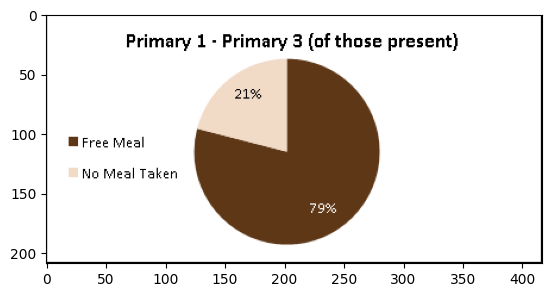

In [27]:
img = cv2.imread("./dataset/data/piedata(1008)/pie/images/val2019/" + data["images"][1]["file_name"])
plt.imshow(img)

In [29]:
annotations_df[annotations_df["image_id"] == 75000]

,image_id,category_id,bbox,area,id
2,75000,0,"[202.0, 37.0, 126.0, 96.0, 202.0, 115.0]",4050.666262,433874
3,75000,0,"[126.0, 96.0, 202.0, 37.0, 202.0, 115.0]",4050.666262,433875
